             Stock
count   248.000000
mean   1545.911895
std     156.375082
min    1190.340000
25%    1429.807500
50%    1552.115000
75%    1641.837500
max    1921.920000


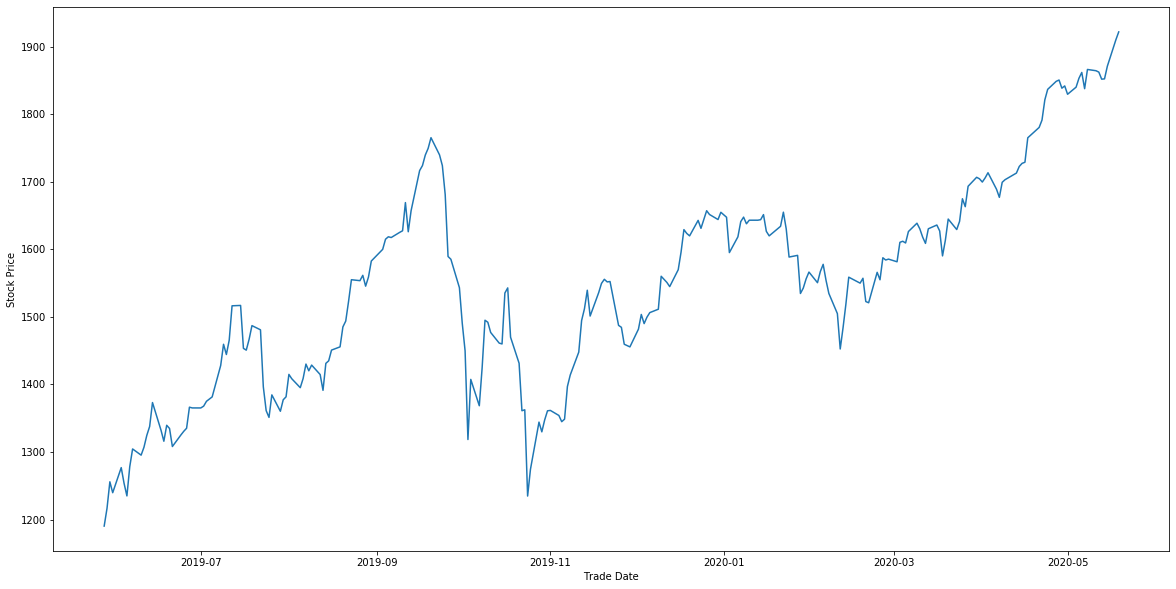

In [51]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split

df = pd.read_csv('sample_ts.csv', parse_dates=['Date'], index_col=['Date'])
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False)
print(df.describe())

plt.figure(figsize=(20,10))
plt.xlabel('Trade Date')
plt.ylabel('Stock Price')
plt.plot(df)
plt.show()

In [52]:
def test_stationarity(ts, window):
    roll_mean = ts.rolling(window=window).mean()
    roll_std = ts.rolling(window=window).std()
    plt.figure(figsize=(20,10))
    plt.plot(ts, label='raw')
    plt.plot(roll_mean,label='rolling mean')
    plt.plot(roll_std, label='rolling std')
    plt.legend(loc='best')
    plt.title('raw vs rolling mean vs rolling std')
    plt.show()

    result = adfuller(ts['Stock'])
    print('ADF: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('critical values:')
    for key, value in result[4].items():
        print('{}: {}'.format(key, value))
    if result[0]> result[4]['5%']:
        print("has unit roots, non stationary")
    else:
        print("no unit roots, stationary")

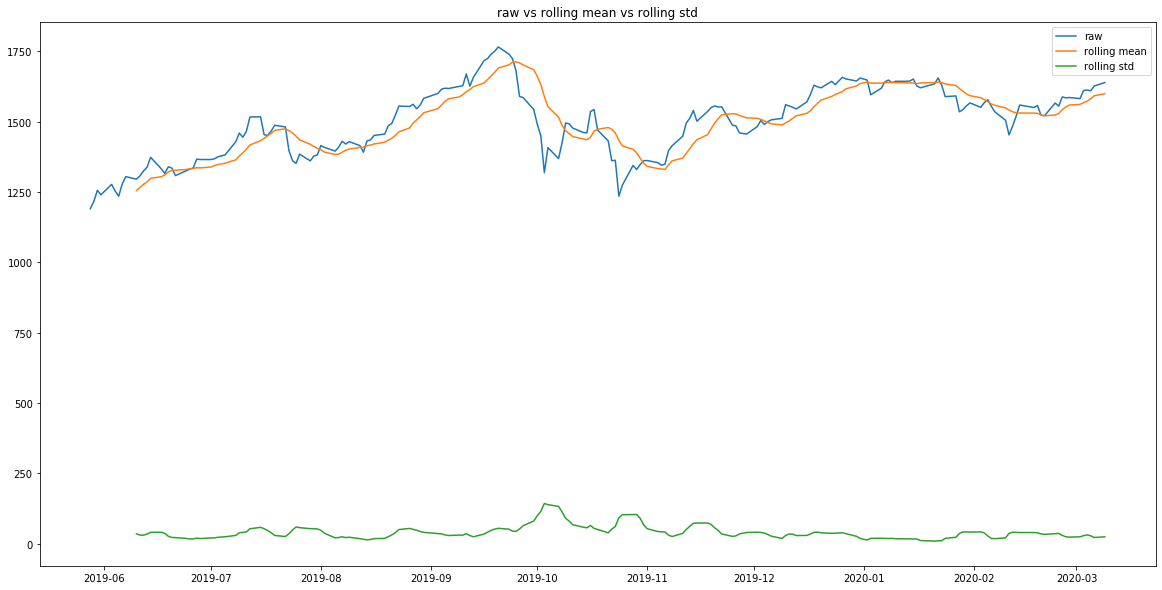

ADF: -2.4852567276506026
p-value: 0.11910285573068724
critical values:
1%: -3.463987334463603
5%: -2.8763259091636213
10%: -2.5746515171738515
has unit roots, non stationary


In [53]:
# choose good window for smoothing
# tested N = 5 vs N = 10 and SMA vs EMA
window = 10
test_stationarity(train_df, window=window)

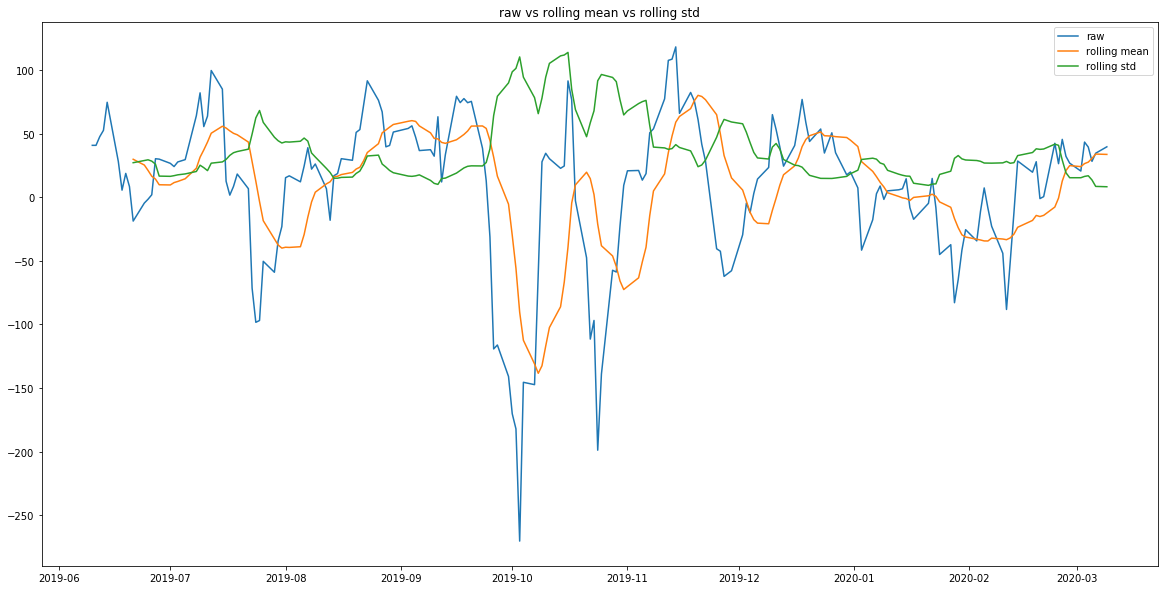

ADF: -5.1323111123205525
p-value: 1.2066561573613606e-05
critical values:
1%: -3.466598080268425
5%: -2.8774669520682674
10%: -2.5752604356654425
no unit roots, stationary


In [54]:
# simple MA smoothing
rolling_mean = train_df.rolling(window=window).mean()
df_sma = train_df - rolling_mean
df_sma.dropna(inplace=True)

test_stationarity(df_sma, window)

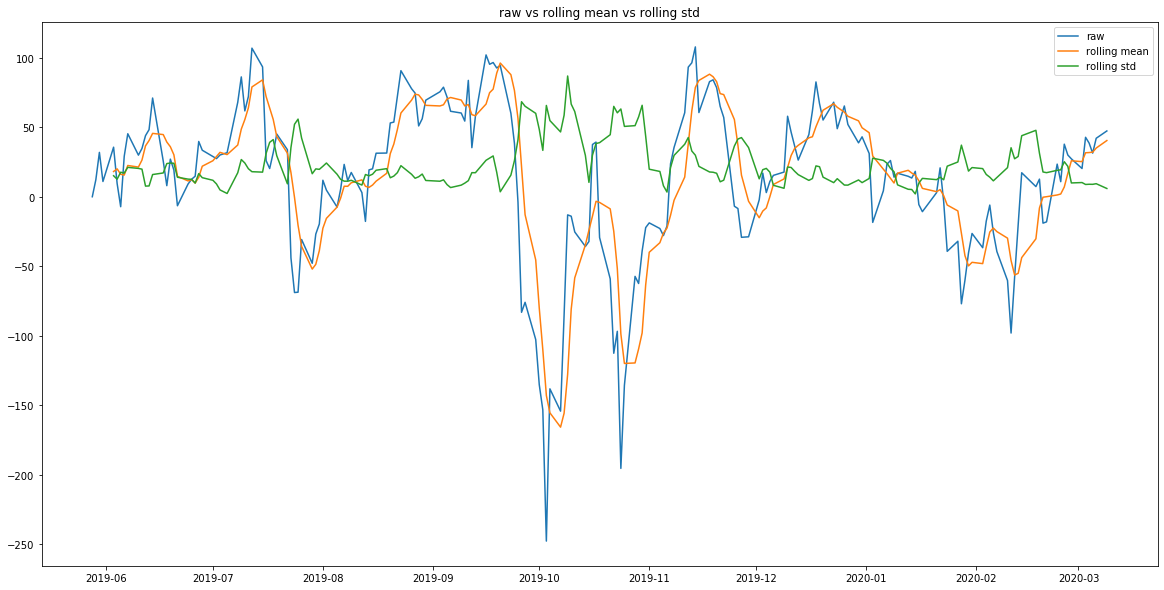

ADF: -3.5218276599493494
p-value: 0.007443893268712038
critical values:
1%: -3.463987334463603
5%: -2.8763259091636213
10%: -2.5746515171738515
no unit roots, stationary


In [62]:
# exponential MA smoothing
ema_window = 5
rolling_mean_exp = train_df.ewm(halflife=ema_window).mean()
df_ema = train_df - rolling_mean_exp
df_ema.dropna(inplace=True)
test_stationarity(df_ema, ema_window)

# Conclusion: SMA with N=10 is the best so far

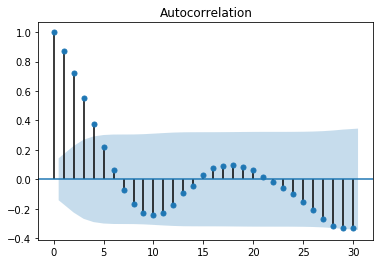

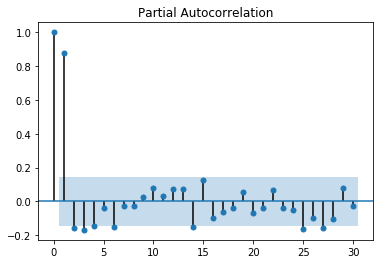

In [56]:
# SMA N=10 ACF and PACF
plot_acf(df_sma, lags=30)
plot_pacf(df_sma, lags=30);

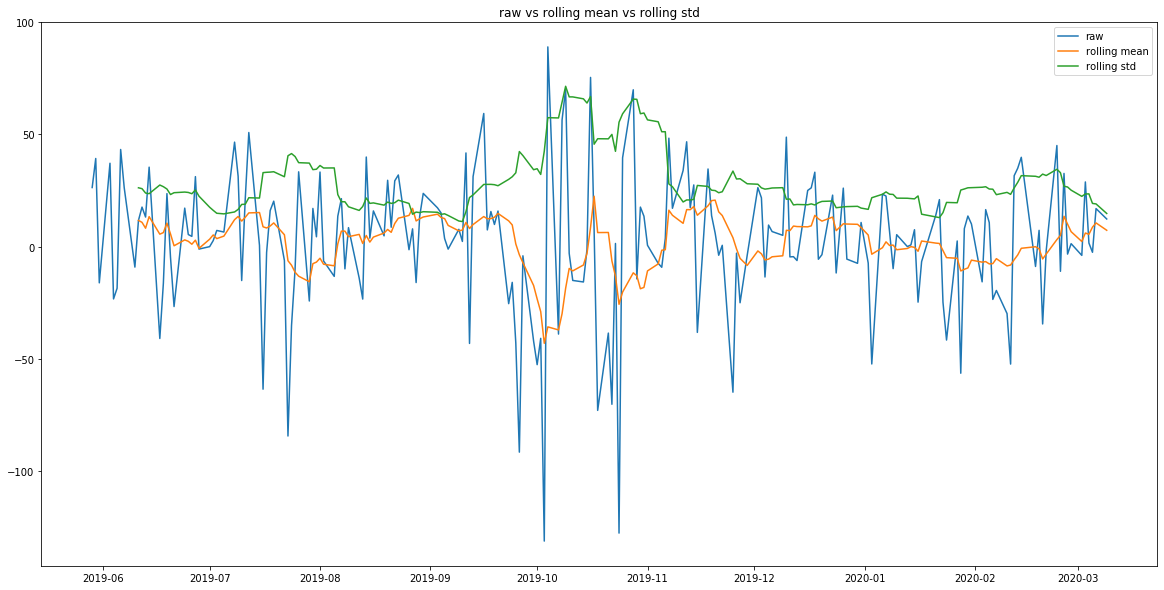

ADF: -13.091052159318751
p-value: 1.7882031779044177e-24
critical values:
1%: -3.464161278384219
5%: -2.876401960790147
10%: -2.5746921001665974
no unit roots, stationary


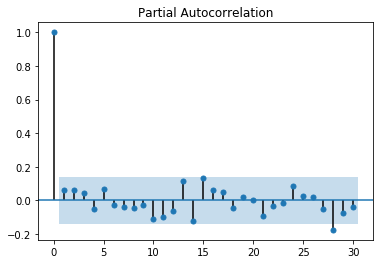

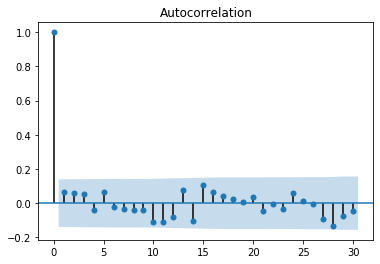

In [57]:
# Finite differences model (first difference)
first_diff = train_df.diff(periods=1).dropna()
test_stationarity(first_diff, window)

# Conclusion: d = 1 is good enough

# Compare EMA vs first_diff
plot_pacf(first_diff, lags=30)
plot_acf(first_diff, lags=30);

# Conclusion: first_diff model is thee way to go
# ADF test value is the lowest <-> p-value is the lowest -> best model

# Final model ARIMA(1,1,1)

/Users/nikkatalnikov/opt/anaconda3/envs/kpi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/nikkatalnikov/opt/anaconda3/envs/kpi/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Stock   No. Observations:                  197
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -958.270
Method:                       css-mle   S.D. of innovations             31.354
Date:                Sat, 30 May 2020   AIC                           1924.541
Time:                        04:42:12   BIC                           1937.674
Sample:                             1   HQIC                          1929.857
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.3265      2.607      0.892      0.372      -2.783       7.436
ar.L1.D.Stock     0.5838      0.362      1.613      0.107      -0.126       1.293
ma.L1.D.Stock    -0.5136      0.379     

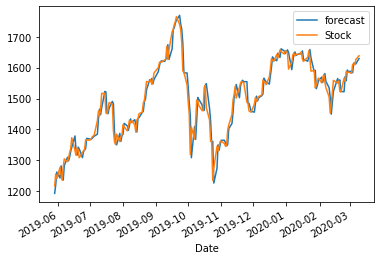

In [58]:
# Fit model
model = ARIMA(train_df, order=(1,1,1)).fit(disp=-1)
print(model.summary())
model.plot_predict();

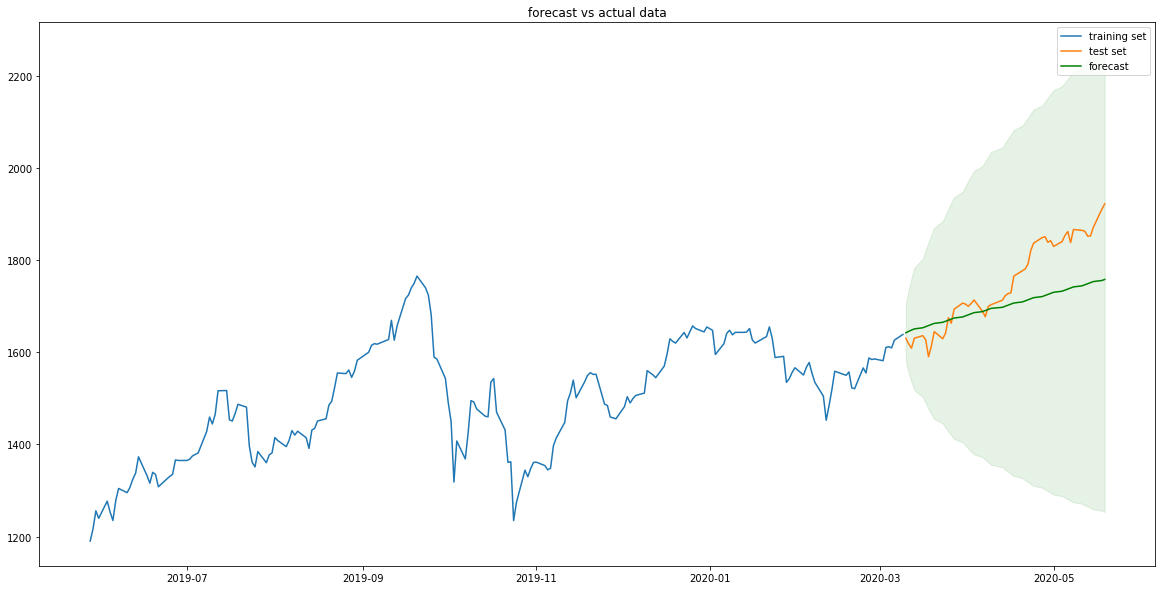

In [59]:
# Forecast

# forecast, standard error, 95% confidence interval
forecast, se, conf = model.forecast(50, alpha=0.05)  

fc_series = pd.Series(forecast, index=test_df.index)
lower_series = pd.Series(conf[:, 0], index=test_df.index)
upper_series = pd.Series(conf[:, 1], index=test_df.index)

plt.figure(figsize=(20,10))
plt.plot(train_df, label='training set')
plt.plot(test_df, label='test set')
plt.plot(fc_series, label='forecast', color='green')
plt.fill_between(lower_series.index, lower_series, upper_series, color='green', alpha=.1)
plt.title('forecast vs actual data')
plt.legend(loc='best');

In [60]:
# Numerical tests

e2 = (test_df.values - forecast)**2
rss = np.sum(e2)
rmse = np.mean(e2)**0.5
r2 = r2_score(test_df.values, forecast)

print('RSS: {}'.format(rss))
print('RMSE: {}'.format(rmse))
print('R^2: {}'.format(r2))


RSS: 31018958.234404944
RMSE: 111.3893320464845
R^2: 0.30318018334165175
